In [1]:
! git clone https://github.com/wingedrasengan927/Stereo-Geometry.git
! ls

Cloning into 'Stereo-Geometry'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 24 (delta 2), reused 24 (delta 2), pack-reused 0
Receiving objects: 100% (24/24), 6.72 MiB | 10.99 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Stereo-Geometry		    tiny_nerf_data.npz
Stereo_Rectification.ipynb  tiny_nerf_pytorch_.ipynb


In [2]:
%cd Stereo-Geometry/
! pip install -r requirements.txt

/workspace/junghyeon/NeRF/Stereo-Geometry
     |████████████████████████████████| 96 kB 5.8 MB/s  eta 0:00:01


  Created wheel for pytransform3d: filename=pytransform3d-3.2.0-py3-none-any.whl size=100646 sha256=26a5fd5b8ec4991b034483c66282a2917f3774e4a355beaf818e0301b2fb057c
  Stored in directory: /root/.cache/pip/wheels/81/db/c1/c85c2127805c6ff71ed8dcbffac82cec02ab726edcc15a28c5
Successfully built pytransform3d


In [4]:
%matplotlib widget

import matplotlib.pyplot as plt
from skimage import io
from skimage.transform import resize
from skimage.transform import warp, ProjectiveTransform
from stereo_utils import *
from skimage.color import rgb2gray, rgba2rgb

# Plot Images and Matching Points

두 이미지와 대응되는 Feature Point에 대한 정보를 불러온다.

In [5]:
# load images
im1 = io.imread("data/bench/right.png")
im1 = rgb2gray(rgba2rgb(im1))
im2 = io.imread("data/bench/left.png")
im2 = rgb2gray(rgba2rgb(im2))

# load matching points
points1 = np.load("data/bench/right_points.npy")
points2 = np.load("data/bench/left_points.npy")

assert (points1.shape == points2.shape)

## Plot matching points

두 이미지와 대응되는 Feature Point 시각화

In [6]:
from google.colab import output
output.enable_custom_widget_manager()

ModuleNotFoundError: No module named 'google.colab'

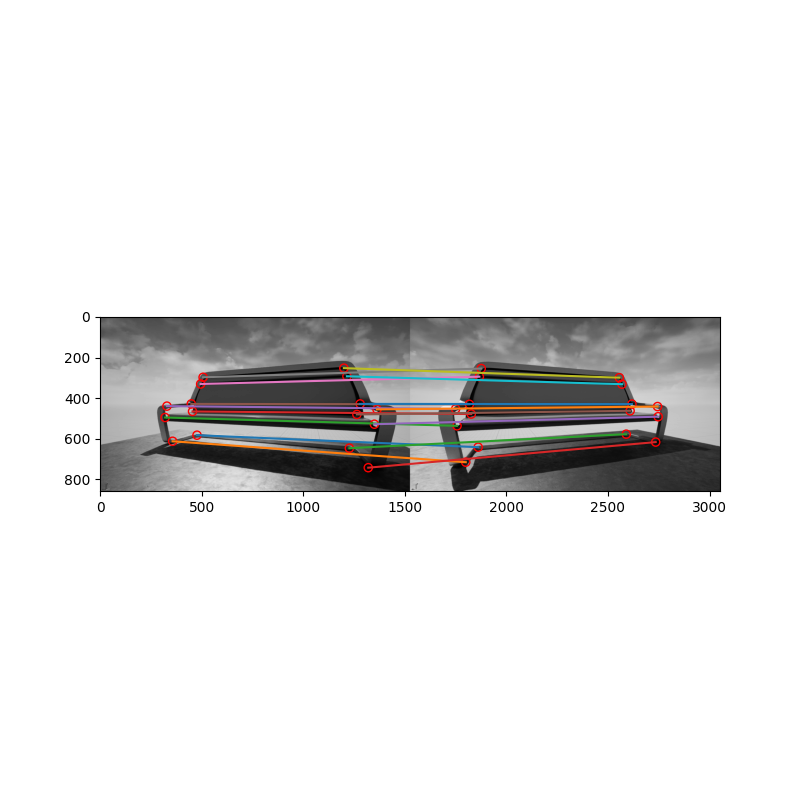

In [7]:
show_matching_result(im1, im2, points1, points2)

# Epipolar Geometry

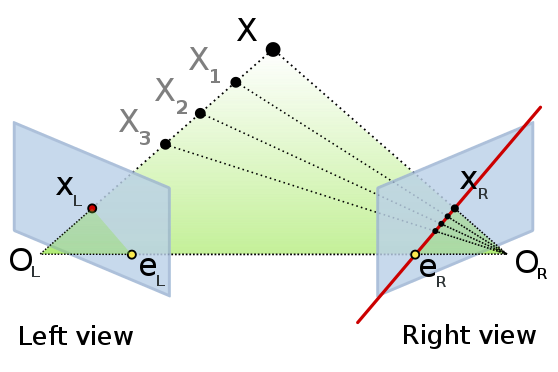

## $X^T_RFX_L = 0$
- $X_R$ : Right view homogeneous image coordinate
- $X_L$ : Left view homogeneous image coordinate
- $F$ : Fundamental matrix (3x3 matrix)

# The Fundamental Matrix

3차원 공간 상에서 두 영상 사이의 관계를 파악하기 위해 사용하는 행렬입니다.

In [8]:
# Compute the noramlized fundamental matrix
F = compute_fundamental_matrix_normalized(points1, points2)

In [9]:
# Validate the fundamental matrix equation
p1 = points1.T[:, 0]
p2 = points2.T[:, 0]

np.round(p2.T @ F @ p1)

0.0

## Plot Epipolar lines



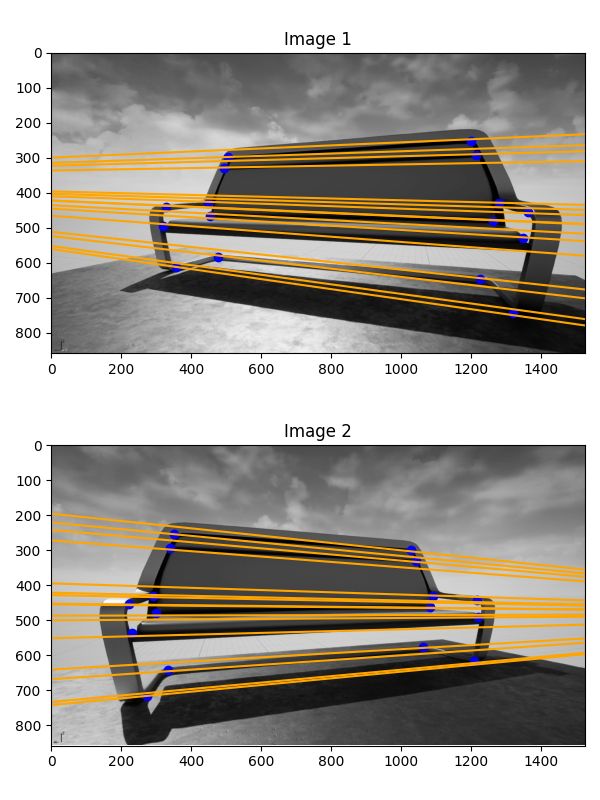

In [10]:
plot_epipolar_lines(im1, im2, points1, points2, show_epipole=False)

## Plot Epipoles

In [11]:
e1 = compute_epipole(F)
e2 = compute_epipole(F.T)

In [12]:
# Validate fundamental matrix equation for epipoles
np.round(e2.T @ F @ e1)

0.0

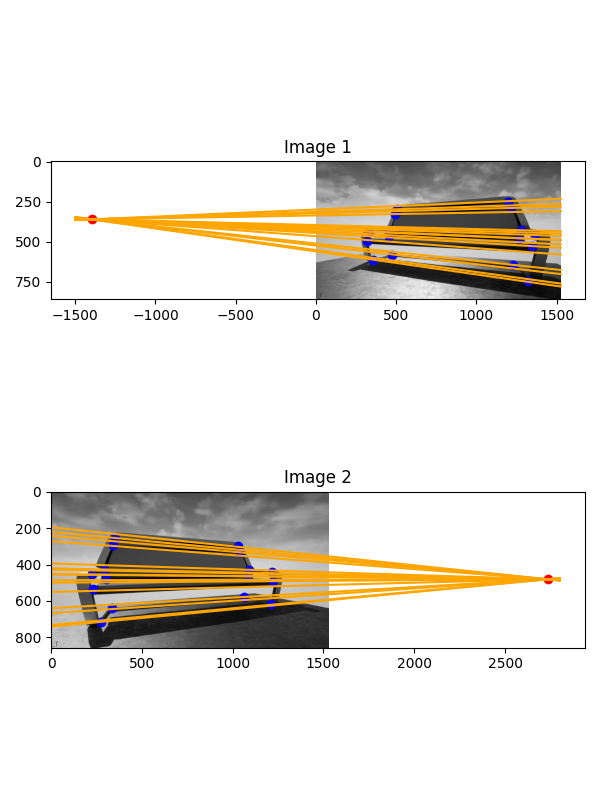

In [13]:
plot_epipolar_lines(im1, im2, points1, points2, show_epipole=True)

# Stereo Rectification

Stereo Rectification는 각 이미지에 대해 대응되는 Epipolar line을 평행하도록 
이미지를 변환하여 두 이미지 사이에 대응되는 점을 탐색하는 과정을 단순화하기 위한 작업입니다.

In [14]:
H1, H2 = compute_matching_homographies(e2, F, im2, points1, points2)

In [15]:
# Transform points based on the homography matrix
new_points1 = H1 @ points1.T
new_points2 = H2 @ points2.T
new_points1 /= new_points1[2,:]
new_points2 /= new_points2[2,:]
new_points1 = new_points1.T
new_points2 = new_points2.T

# warp images based on the homography matrix
im1_warped = warp(im1, ProjectiveTransform(matrix=np.linalg.inv(H1)))
im2_warped = warp(im2, ProjectiveTransform(matrix=np.linalg.inv(H2)))

## Plot the new epipolar lines and matching points

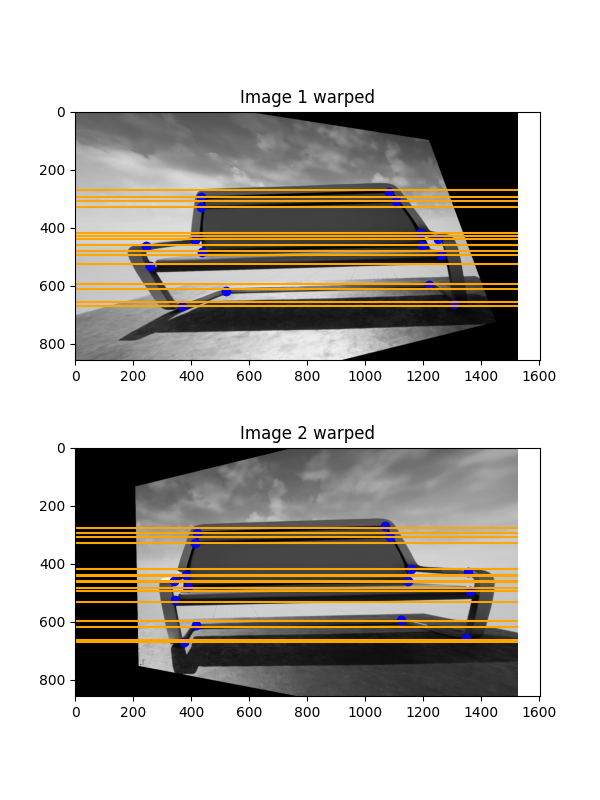

In [16]:
h, w = im1.shape

nrows = 2
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6, 8))

# plot image 1
ax1 = axes[0]
ax1.set_title("Image 1 warped")
ax1.imshow(im1_warped, cmap="gray")

# plot image 2
ax2 = axes[1]
ax2.set_title("Image 2 warped")
ax2.imshow(im2_warped, cmap="gray")

# plot the epipolar lines and points
n = new_points1.shape[0]
for i in range(n):
    p1 = new_points1[i]
    p2 = new_points2[i]

    ax1.hlines(p2[1], 0, w, color="orange")
    ax1.scatter(*p1[:2], color="blue")

    ax2.hlines(p1[1], 0, w, color="orange")
    ax2.scatter(*p2[:2], color="blue")